In [1]:
import os
import os.path
import shutil
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.nn import init


def get_data_loader(dataset, batch_size, cuda=False, collate_fn=None):

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=(collate_fn or default_collate),
        # **({"num_workers": 2, "pin_memory": True} if cuda else {})
    )


def save_checkpoint(model, model_dir, epoch, precision, best=True):
    path = os.path.join(model_dir, model.name)
    path_best = os.path.join(model_dir, "{}-best".format(model.name))

    # save the checkpoint.
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    torch.save(
        {
            "state": model.state_dict(),
            "epoch": epoch,
            "precision": precision,
        },
        path,
    )

    # override the best model if it's the best.
    if best:
        shutil.copy(path, path_best)
        print(
            "=> updated the best model of {name} at {path}".format(
                name=model.name, path=path_best
            )
        )

    # notify that we successfully saved the checkpoint.
    print("=> saved the model {name} to {path}".format(name=model.name, path=path))


def load_checkpoint(model, model_dir, best=True):
    path = os.path.join(model_dir, model.name)
    path_best = os.path.join(model_dir, "{}-best".format(model.name))

    # load the checkpoint.
    checkpoint = torch.load(path_best if best else path)
    print(
        "=> loaded checkpoint of {name} from {path}".format(
            name=model.name, path=(path_best if best else path)
        )
    )

    # load parameters and return the checkpoint's epoch and precision.
    model.load_state_dict(checkpoint["state"])
    epoch = checkpoint["epoch"]
    precision = checkpoint["precision"]
    return epoch, precision


def validate(model, dataset, test_size=256, batch_size=32, cuda=False, verbose=True):
    mode = model.training
    model.train(mode=False)
    data_loader = get_data_loader(dataset, batch_size, cuda=cuda)
    total_tested = 0
    total_correct = 0
    for x, y in data_loader:
        # break on test size.
        if total_tested >= test_size:
            break
        # test the model.
        x = x.view(batch_size, -1)
        x = Variable(x).cuda() if cuda else Variable(x)
        y = Variable(y).cuda() if cuda else Variable(y)
        scores = model(x)
        _, predicted = scores.max(1)
        # update statistics.
        total_correct += int((predicted == y).sum())
        total_tested += len(x)
    model.train(mode=mode)
    precision = total_correct / total_tested
    if verbose:
        print("=> precision: {:.3f}".format(precision))
    return precision


def xavier_initialize(model):
    modules = [m for n, m in model.named_modules() if "conv" in n or "linear" in n]

    parameters = [p for m in modules for p in m.parameters() if p.dim() >= 2]

    for p in parameters:
        init.xavier_normal(p)


def gaussian_intiailize(model, std=0.1):
    for p in model.parameters():
        init.normal(p, std=std)


In [2]:
from functools import reduce
import torch
from torch import nn
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable


class MLP(nn.Module):
    def __init__(self, input_size, output_size,
                 hidden_size=400,
                 hidden_layer_num=2,
                 hidden_dropout_prob=.5,
                 input_dropout_prob=.2,
                 lamda=40):
        # Configurations.
        super().__init__()
        self.input_size = input_size
        self.input_dropout_prob = input_dropout_prob
        self.hidden_size = hidden_size
        self.hidden_layer_num = hidden_layer_num
        self.hidden_dropout_prob = hidden_dropout_prob
        self.output_size = output_size
        self.lamda = lamda

        # Layers.
        self.layers = nn.ModuleList([
            # input
            nn.Linear(self.input_size, self.hidden_size), nn.ReLU(),
            nn.Dropout(self.input_dropout_prob),
            # hidden
            *((nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
               nn.Dropout(self.hidden_dropout_prob)) * self.hidden_layer_num),
            # output
            nn.Linear(self.hidden_size, self.output_size)
        ])

    @property
    def name(self):
        return (
            'MLP'
            '-lambda{lamda}'
            '-in{input_size}-out{output_size}'
            '-h{hidden_size}x{hidden_layer_num}'
            '-dropout_in{input_dropout_prob}_hidden{hidden_dropout_prob}'
        ).format(
            lamda=self.lamda,
            input_size=self.input_size,
            output_size=self.output_size,
            hidden_size=self.hidden_size,
            hidden_layer_num=self.hidden_layer_num,
            input_dropout_prob=self.input_dropout_prob,
            hidden_dropout_prob=self.hidden_dropout_prob,
        )

    def forward(self, x):
        return reduce(lambda x, l: l(x), self.layers, x)

    def estimate_fisher(self, dataset, sample_size, batch_size=32):
        # sample loglikelihoods from the dataset.
        data_loader = get_data_loader(dataset, batch_size)
        loglikelihoods = []
        for x, y in data_loader:
            x = x.view(batch_size, -1)
            x = Variable(x).cuda() if self._is_on_cuda() else Variable(x)
            y = Variable(y).cuda() if self._is_on_cuda() else Variable(y)
            loglikelihoods.append(
                F.log_softmax(self(x), dim=1)[range(batch_size), y.data]
            )
            if len(loglikelihoods) >= sample_size // batch_size:
                break
        # estimate the fisher information of the parameters.
        loglikelihoods = torch.cat(loglikelihoods).unbind()
        loglikelihood_grads = zip(*[autograd.grad(
            l, self.parameters(),
            retain_graph=(i < len(loglikelihoods))
        ) for i, l in enumerate(loglikelihoods, 1)])
        loglikelihood_grads = [torch.stack(gs) for gs in loglikelihood_grads]
        fisher_diagonals = [(g ** 2).mean(0) for g in loglikelihood_grads]
        param_names = [
            n.replace('.', '__') for n, p in self.named_parameters()
        ]
        return {n: f.detach() for n, f in zip(param_names, fisher_diagonals)}

    def consolidate(self, fisher):
        for n, p in self.named_parameters():
            n = n.replace('.', '__')
            self.register_buffer('{}_mean'.format(n), p.data.clone())
            self.register_buffer('{}_fisher'
                                 .format(n), fisher[n].data.clone())

    def ewc_loss(self, cuda=False):
        try:
            losses = []
            for n, p in self.named_parameters():
                # retrieve the consolidated mean and fisher information.
                n = n.replace('.', '__')
                mean = getattr(self, '{}_mean'.format(n))
                fisher = getattr(self, '{}_fisher'.format(n))
                # wrap mean and fisher in variables.
                mean = Variable(mean)
                fisher = Variable(fisher)
                # calculate a ewc loss. (assumes the parameter's prior as
                # gaussian distribution with the estimated mean and the
                # estimated cramer-rao lower bound variance, which is
                # equivalent to the inverse of fisher information)
                losses.append((fisher * (p-mean)**2).sum())
            return (self.lamda/2)*sum(losses)
        except AttributeError:
            # ewc loss is 0 if there's no consolidated parameters.
            return (
                Variable(torch.zeros(1)).cuda() if cuda else
                Variable(torch.zeros(1))
            )

    def _is_on_cuda(self):
        return next(self.parameters()).is_cuda


In [3]:
from torch import optim
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm

import matplotlib.pyplot as plt

def train(model, train_datasets, test_datasets, epochs_per_task=10,
          batch_size=64, test_size=1024, consolidate=True,
          fisher_estimation_sample_size=1024,
          lr=1e-3, weight_decay=1e-5,
          loss_log_interval=30,
          eval_log_interval=50,
          cuda=False):
    # prepare the loss criteriton and the optimizer.
    criteriton = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,
                          weight_decay=weight_decay)
    
    # set the model's mode to training mode.
    model.train()

    test_accuracies = np.zeros((len(train_datasets), sum([
                    epochs_per_task * len(d) // batch_size for d in
                    train_datasets[:]
                ])))

    for task, train_dataset in enumerate(train_datasets, 1):
        for epoch in range(1, epochs_per_task+1):
            # prepare the data loaders.
            data_loader = get_data_loader(
                train_dataset, batch_size=batch_size,
                cuda=cuda
            )
            data_stream = tqdm(enumerate(data_loader, 1))

            for batch_index, (x, y) in data_stream:
                # where are we?
                data_size = len(x)
                dataset_size = len(data_loader.dataset)
                dataset_batches = len(data_loader)
                previous_task_iteration = sum([
                    epochs_per_task * len(d) // batch_size for d in
                    train_datasets[:task-1]
                ])
                current_task_iteration = (
                    (epoch-1)*dataset_batches + batch_index
                )
                iteration = (
                    previous_task_iteration +
                    current_task_iteration
                )

                # prepare the data.
                x = x.view(data_size, -1)
                x = Variable(x).cuda() if cuda else Variable(x)
                y = Variable(y).cuda() if cuda else Variable(y)

                # run the model and backpropagate the errors.
                optimizer.zero_grad()
                scores = model(x)
                ce_loss = criteriton(scores, y)
                ewc_loss = model.ewc_loss(cuda=cuda)
                loss = ce_loss + ewc_loss
                loss.backward()
                optimizer.step()

                # calculate the training precision.
                _, predicted = scores.max(1)
                precision = (predicted == y).sum().float() / len(x)

                data_stream.set_description((
                    '=> '
                    'task: {task}/{tasks} | '
                    'epoch: {epoch}/{epochs} | '
                    'progress: [{trained}/{total}] ({progress:.0f}%) | '
                    'prec: {prec:.4} | '
                    'loss => '
                    'ce: {ce_loss:.4} / '
                    'ewc: {ewc_loss:.4} / '
                    'total: {loss:.4}'
                ).format(
                    task=task,
                    tasks=len(train_datasets),
                    epoch=epoch,
                    epochs=epochs_per_task,
                    trained=batch_index*batch_size,
                    total=dataset_size,
                    progress=(100.*batch_index/dataset_batches),
                    prec=float(precision),
                    ce_loss=float(ce_loss),
                    ewc_loss=float(ewc_loss),
                    loss=float(loss),
                ))

                
                

                # names = [
                #     'task {}'.format(i+1) for i in
                #     range(len(train_datasets))
                # ]
                precs = [
                    validate(
                        model, test_datasets[i], test_size=test_size,
                        cuda=cuda, verbose=False,
                    ) if i+1 <= task else 0 for i in
                    range(len(train_datasets))
                ]

                test_accuracies[:, iteration-2] = precs

                # title = (
                #     'precision (consolidated)' if consolidate else
                #     'precision'
                # )
                # visual.visualize_scalars(
                #     vis, precs, names, title,
                #     iteration
                # )

                # title = 'loss (consolidated)' if consolidate else 'loss'
                # visual.visualize_scalars(
                #     vis,
                #     [loss, ce_loss, ewc_loss],
                #     ['total', 'cross entropy', 'ewc'],
                #     title, iteration
                # )

        if consolidate and task < len(train_datasets):
            # estimate the fisher information of the parameters and consolidate
            # them in the network.
            print(
                '=> Estimating diagonals of the fisher information matrix...',
                flush=True, end='',
            )
            model.consolidate(model.estimate_fisher(
                train_dataset, fisher_estimation_sample_size
            ))
            print(' Done!')
    
    return test_accuracies

In [4]:
from torchvision import datasets, transforms


def _permutate_image_pixels(image, permutation):
    if permutation is None:
        return image

    c, h, w = image.size()
    image = image.view(-1, c)
    image = image[permutation, :]
    image.view(c, h, w)
    return image


def get_dataset(name, train=True, download=True, permutation=None):
    dataset_class = AVAILABLE_DATASETS[name]
    dataset_transform = transforms.Compose([
        *AVAILABLE_TRANSFORMS[name],
        transforms.Lambda(lambda x: _permutate_image_pixels(x, permutation)),
    ])

    return dataset_class(
        '../data/{name}'.format(name=name), train=train,
        download=download, transform=dataset_transform,
    )


AVAILABLE_DATASETS = {
    'mnist': datasets.MNIST
}

AVAILABLE_TRANSFORMS = {
    'mnist': [
        transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.Pad(2),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
}

DATASET_CONFIGS = {
    'mnist': {'size': 32, 'channels': 1, 'classes': 10}
}


In [16]:
hidden_size = 400
hidden_layer_num = 2
hidden_dropout_prob=.5
input_dropout_prob=.2
task_number=8
epochs_per_task=3
lamda=80
lr=1e-1
weight_decay=0
batch_size=128
test_size=1024
fisher_estimation_sample_size=1024/4
random_seed=0
cuda=True
eval_log_interval=250
loss_log_interval=250
consolidate=True

In [17]:
import numpy as np
import torch

# decide whether to use cuda or not.
cuda = torch.cuda.is_available()

# generate permutations for the tasks.
np.random.seed(random_seed)
permutations = [
    np.random.permutation(DATASET_CONFIGS['mnist']['size']**2) for
    _ in range(task_number)
]

# prepare mnist datasets.
train_datasets = [
    get_dataset('mnist', permutation=p) for p in permutations
]
test_datasets = [
    get_dataset('mnist', train=False, permutation=p) for p in permutations
]

In [18]:
mlp = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size=hidden_size,
    hidden_layer_num=hidden_layer_num,
    hidden_dropout_prob=hidden_dropout_prob,
    input_dropout_prob=input_dropout_prob,
    lamda=lamda,
)

# initialize the parameters.
xavier_initialize(mlp)

# prepare the cuda if needed.
if cuda:
    mlp.cuda()

# run the experiment.
test_accuracies = train(
    mlp, train_datasets, test_datasets,
    epochs_per_task=epochs_per_task,
    batch_size=batch_size,
    test_size=test_size,
    consolidate=consolidate,
    fisher_estimation_sample_size=fisher_estimation_sample_size,
    lr=lr,
    weight_decay=weight_decay,
    eval_log_interval=eval_log_interval,
    loss_log_interval=loss_log_interval,
    cuda=cuda,
)

=> task: 1/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3069 / ewc: 0.0 / total: 0.3069: : 469it [04:48,  1.62it/s]
=> task: 1/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.07229 / ewc: 0.0 / total: 0.07229: : 469it [05:11,  1.51it/s]
=> task: 1/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.15 / ewc: 0.0 / total: 0.15: : 469it [03:56,  1.98it/s]      

=> Estimating diagonals of the fisher information matrix...

 Done!


=> task: 2/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.145 / ewc: 0.05315 / total: 0.1981: : 469it [07:20,  1.06it/s] 
=> task: 2/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2185 / ewc: 0.05901 / total: 0.2775: : 469it [07:17,  1.07it/s] 
=> task: 2/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.3801 / ewc: 0.06051 / total: 0.4406: : 469it [06:54,  1.13it/s] 

=> Estimating diagonals of the fisher information matrix...

 Done!


=> task: 3/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.1224 / ewc: 0.08072 / total: 0.2031: : 469it [10:31,  1.35s/it]
=> task: 3/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1123 / ewc: 0.07826 / total: 0.1906: : 469it [10:16,  1.31s/it]
=> task: 3/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1729 / ewc: 0.07478 / total: 0.2476: : 469it [10:37,  1.36s/it]

=> Estimating diagonals of the fisher information matrix...

 Done!


=> task: 4/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1373 / ewc: 0.09788 / total: 0.2352: : 469it [14:34,  1.86s/it]
=> task: 4/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.1847 / ewc: 0.08264 / total: 0.2674: : 469it [14:36,  1.87s/it]
=> task: 4/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.09862 / ewc: 0.07758 / total: 0.1762: : 469it [14:27,  1.85s/it]

=> Estimating diagonals of the fisher information matrix...

 Done!


=> task: 5/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9167 | loss => ce: 0.2268 / ewc: 0.08275 / total: 0.3095: : 469it [17:06,  2.19s/it]
=> task: 5/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.1233 / ewc: 0.07222 / total: 0.1955: : 469it [16:17,  2.09s/it]
=> task: 5/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1987 / ewc: 0.06556 / total: 0.2642: : 469it [16:14,  2.08s/it]

=> Estimating diagonals of the fisher information matrix...

 Done!


=> task: 6/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1255 / ewc: 0.07328 / total: 0.1987: : 469it [19:21,  2.48s/it]
=> task: 6/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.1178 / ewc: 0.06342 / total: 0.1813: : 469it [19:23,  2.48s/it]
=> task: 6/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.15 / ewc: 0.06094 / total: 0.2109: : 469it [19:23,  2.48s/it]  

=> Estimating diagonals of the fisher information matrix...

 Done!


=> task: 7/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.2835 / ewc: 0.071 / total: 0.3545: : 469it [22:34,  2.89s/it]  
=> task: 7/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1419 / ewc: 0.06321 / total: 0.2051: : 469it [22:33,  2.89s/it]
=> task: 7/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1165 / ewc: 0.05602 / total: 0.1725: : 469it [22:33,  2.89s/it]

=> Estimating diagonals of the fisher information matrix...

 Done!


=> task: 8/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2233 / ewc: 0.081 / total: 0.3043: : 469it [5:36:21, 43.03s/it]   
=> task: 8/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.2328 / ewc: 0.07442 / total: 0.3072: : 469it [27:07,  3.47s/it]
=> task: 8/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9792 | loss => ce: 0.05808 / ewc: 0.07135 / total: 0.1294: : 469it [27:48,  3.56s/it]


In [11]:
def accuracy_plot(x):
    for t, v in enumerate(x):
      plt.plot(list(range(sum([epochs_per_task * len(d) // batch_size for d in train_datasets[:]]))), v)
    plt.ylim(0, 1)

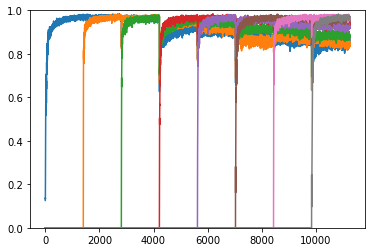

In [19]:
accuracy_plot(test_accuracies)

In [9]:
mlp2 = MLP(
    DATASET_CONFIGS['mnist']['size']**2,
    DATASET_CONFIGS['mnist']['classes'],
    hidden_size=hidden_size,
    hidden_layer_num=hidden_layer_num,
    hidden_dropout_prob=hidden_dropout_prob,
    input_dropout_prob=input_dropout_prob,
    lamda=lamda,
)

# initialize the parameters.
xavier_initialize(mlp2)

# prepare the cuda if needed.
if cuda:
    mlp2.cuda()

# run the experiment.
test_accuracies2 = train(
    mlp2, train_datasets, test_datasets,
    epochs_per_task=epochs_per_task,
    batch_size=batch_size,
    test_size=test_size,
    consolidate=False,
    fisher_estimation_sample_size=fisher_estimation_sample_size,
    lr=lr,
    weight_decay=weight_decay,
    eval_log_interval=eval_log_interval,
    loss_log_interval=loss_log_interval,
    cuda=cuda,
)

=> task: 1/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9271 | loss => ce: 0.2115 / ewc: 0.0 / total: 0.2115: : 469it [04:13,  1.85it/s]
=> task: 1/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9583 | loss => ce: 0.1707 / ewc: 0.0 / total: 0.1707: : 469it [03:51,  2.03it/s] 
=> task: 1/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.8958 | loss => ce: 0.3567 / ewc: 0.0 / total: 0.3567: : 469it [03:49,  2.04it/s]  
=> task: 2/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9479 | loss => ce: 0.1497 / ewc: 0.0 / total: 0.1497: : 469it [07:08,  1.09it/s] 
=> task: 2/8 | epoch: 2/3 | progress: [60032/60000] (100%) | prec: 0.9062 | loss => ce: 0.3167 / ewc: 0.0 / total: 0.3167: : 469it [07:09,  1.09it/s] 
=> task: 2/8 | epoch: 3/3 | progress: [60032/60000] (100%) | prec: 0.9688 | loss => ce: 0.04627 / ewc: 0.0 / total: 0.04627: : 469it [07:09,  1.09it/s]
=> task: 3/8 | epoch: 1/3 | progress: [60032/60000] (100%) | prec: 0.9375 | loss => ce: 0.234

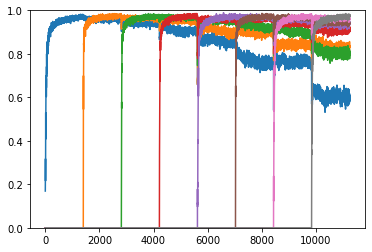

In [12]:
accuracy_plot(test_accuracies2)

In [20]:
torch.save(mlp.state_dict(), 'ewc_8_tasks_MNIST.pt')

In [15]:
torch.save(mlp2.state_dict(), 'sgd_8_tasks_MNIST.pt')